# The lapidarist problem

In [78]:
#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn modules
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

#Sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

#Sklearn metrics
from sklearn.metrics import mean_squared_error as mse, r2_score as r2, mean_absolute_error as mae

### Loading and exploring data

In [79]:
diamons_data = pd.read_csv(r'diamonds_data\diamonds.csv')
diamons_coords = pd.read_csv(r'diamonds_data\coords_diamonds.csv')

In [80]:
diamons_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [81]:
diamons_coords.head()

,Unnamed: 0,latitude,longitude
0,0,39.8813889,-83.093056
1,1,33.4150000,-111.548889
2,2,40.1672222,-105.101389
3,3,37.3711111,-85.583056
4,4,48.5394444,-121.745000


We can see as principal difference between Krenk’s diamonds data and the dataset provided, that the latitude and longitude comes in diferents dataframes so it is necesary to make a join with the column named "Unnamed: 0" that works as an id for each diamond.

In [82]:
diamons_data = diamons_data.merge(right=diamons_coords, how ='left', on='Unnamed: 0').drop('Unnamed: 0', axis=1)

In [83]:
diamons_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,latitude,longitude
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,39.8813889,-83.093056
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,33.4150000,-111.548889
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,40.1672222,-105.101389
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,37.3711111,-85.583056
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,48.5394444,-121.745000


On the other hand it's necesary to make a data frame with the Krenk’s diamonds data with the same format.

In [84]:
diamons_stolen = pd.read_csv(r'Krenks diamonds.csv').drop('Unnamed: 0', axis=1)
diamons_stolen.head()

,Carat,Cut,Color,Clarity,Depth,Table,x,y,z,coordinates
0,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,"35.02636, -114.38351"
1,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,"35.00350, -109.78961"
2,0.50,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,"35.10544, -106.669673"
3,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,"34.94666, -104.64730"
4,0.32,Premium,G,VS1,62.1,56.0,4.43,4.40,2.74,"35.18864, -101.98602"


In [85]:
coordinates = diamons_stolen.pop('coordinates')
latitud = []
longitude = []
for i in range(len(coordinates)):
    latitud.append(coordinates[i].split(',')[0])
    longitude.append(coordinates[i].split(',')[1])

diamons_stolen['latitude'] = pd.Series(latitud, dtype=float)
diamons_stolen['longitude'] = pd.Series(longitude, dtype=float)
diamons_stolen.head()

,Carat,Cut,Color,Clarity,Depth,Table,x,y,z,latitude,longitude
0,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,35.02636,-114.383510
1,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,35.00350,-109.789610
2,0.50,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,35.10544,-106.669673
3,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,34.94666,-104.647300
4,0.32,Premium,G,VS1,62.1,56.0,4.43,4.40,2.74,35.18864,-101.986020


In [86]:
diamons_stolen.describe()

,Carat,Depth,Table,x,y,z,latitude,longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.604000,62.180000,56.680000,5.305000,5.332000,3.309000,35.856825,-101.341053
std,0.271506,0.736056,1.592203,0.756575,0.767547,0.486586,1.293103,7.659776
min,0.320000,60.900000,54.800000,4.430000,4.400000,2.740000,34.946660,-114.383510
25%,0.392500,61.725000,55.250000,4.682500,4.717500,2.905000,35.046130,-106.164080
50%,0.505000,62.100000,56.500000,5.155000,5.165000,3.160000,35.227375,-100.812380
75%,0.800000,62.625000,57.750000,5.925000,5.965000,3.707500,36.001634,-96.237325
max,1.120000,63.300000,59.000000,6.640000,6.660000,4.130000,38.663030,-90.218080


## Cleaning data

### Numerical variables

In [87]:
diamons_data.describe()

,carat,depth,table,price,x,y,z,longitude
count,53930.000000,50968.000000,53930.000000,53930.000000,52840.000000,53345.000000,53930.000000,53930.000000
mean,0.797976,61.749425,57.457328,3933.054942,5.730617,5.733112,3.538141,-86.693792
std,0.474035,1.432949,2.234578,3989.628569,1.127572,1.141865,0.708909,39.773132
min,0.200000,43.000000,43.000000,326.000000,-6.370000,-6.610000,-4.060000,-173.985008
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,-112.073333
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,-87.889167
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000,-78.680278
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,178.017649


From here we can see:
- "latitude" is not considered as a numerical variable.
- There are missing values (nans)
- Negative values in x,y,z

In [88]:
for element in diamons_data['latitude']:
    try:
        float(element)
    except:
        print(i,element)

9 33q.200088


In [89]:
diamons_data['latitude'] = diamons_data['latitude'].str.replace('q', '').values.astype(float)

In [90]:
diamons_data.describe()

,carat,depth,table,price,x,y,z,latitude,longitude
count,53930.000000,50968.000000,53930.000000,53930.000000,52840.000000,53345.000000,53930.000000,53930.000000,53930.000000
mean,0.797976,61.749425,57.457328,3933.054942,5.730617,5.733112,3.538141,38.137352,-86.693792
std,0.474035,1.432949,2.234578,3989.628569,1.127572,1.141865,0.708909,10.485185,39.773132
min,0.200000,43.000000,43.000000,326.000000,-6.370000,-6.610000,-4.060000,-82.862752,-173.985008
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000,34.147778,-112.073333
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,39.457778,-87.889167
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000,42.800556,-78.680278
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,72.700000,178.017649


As x, y, z measure the diamond dimensions they must be more than 0 but in the description we can see that the min value for these variables are negatives. Their means (5.730617,5.733112,3.538141) must be relatively "small" which is correct. 

In [91]:
numeric_cols = diamons_data.select_dtypes(include=[np.number])
(numeric_cols<=0).sum() 

carat             0
depth             0
table             0
price             0
x                13
y                12
z                25
latitude        727
longitude     52045
dtype: int64

As there are few values lower than zero let's take them as nans. Considering them as positives could give errors in the future predictions.

In [92]:
diamons_data.isnull().sum()/len(diamons_data)

carat         0.000000
cut           0.000000
color         0.000000
clarity       0.000000
depth         0.054923
table         0.000000
price         0.000000
x             0.020211
y             0.010847
z             0.000000
latitude      0.000000
longitude     0.000000
dtype: float64

In [93]:
diamons_data[diamons_data['x']<=0] = 0
diamons_data[diamons_data['y']<=0] = 0
diamons_data[diamons_data['z']<=0] = 0
diamons_data.replace(0, np.nan, inplace=True)

In [94]:
diamons_data.describe()

,carat,depth,table,price,x,y,z,latitude,longitude
count,53895.000000,50935.000000,53895.000000,53895.000000,52805.000000,53310.000000,53895.000000,53895.000000,53895.000000
mean,0.797778,61.749569,57.457031,3931.530995,5.732237,5.734533,3.540144,38.137839,-86.691787
std,0.473853,1.432576,2.234257,3987.729587,1.119916,1.135014,0.702595,10.483650,39.778770
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000,-82.862752,-173.985008
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000,34.147778,-112.073333
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000,39.457500,-87.889167
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000,42.800556,-78.680278
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,72.700000,178.017649


### Nans

Let's see the propostions of nans in the dataset

In [95]:
diamons_data.isnull().sum()/len(diamons_data)

carat         0.000649
cut           0.000649
color         0.000649
clarity       0.000649
depth         0.055535
table         0.000649
price         0.000649
x             0.020860
y             0.011496
z             0.000649
latitude      0.000649
longitude     0.000649
dtype: float64

As we can see the proportion of nans in the dataframe are minimal so the best focus is to remove the rows that contains the nans.

In [96]:
len_original_data = len(diamons_data)
print('Number of rows before remove the nans: ', len_original_data)
diamons_data.dropna(inplace=True)
print('Number of rows after remove the nans: ', len(diamons_data))

Number of rows before remove the nans:  53930
Number of rows after remove the nans:  50935


### Categorical variables

In [97]:
diamons_data.select_dtypes(include=[object]).describe()

,cut,color,clarity
count,50935,50935,50935
unique,25,26,30
top,Ideal,G,SI1
freq,20276,10614,12364


We can see a lot of unique values so let's see the possible values in the categorical variables

In [98]:
cat_cols = diamons_data.select_dtypes(include=[object]).columns
for col in cat_cols:
    print('{} values: {}\n'.format(col, diamons_data[col].unique()))

cut values: ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair' 'Very Goo!d' "P*'remium"
 'I#deal' '#Very Good' 'P?remium' "*'Ideal" '!Good' 'Pre!mium' 'Pr?emium'
 'Very Go#od' 'Ide&al' 'Id!eal' '&Premium' 'Go?od' 'G#ood' "Very *'Good"
 "Ide*'al" 'V&ery Good' '&Ideal' 'Very G#ood']

color values: ['E' 'I' 'J' 'H' 'F' 'G' 'D' "*'E" '#F' '&G' '!H' '?J' '#D' '&I' '!I' '?G'
 '#H' '?H' '?E' "*'F" '!E' '&F' '#G' "*'I" '!F' '&E']

clarity values: ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF' 'S?I1' 'SI!1' '&SI2'
 "S*'I1" 'VS?1' "S*'I2" '#VS1' 'V&S2' 'V!S2' '!VS2' 'VS#2' "VVS*'2"
 "*'SI2" 'VV?S1' 'S&I1' "*'SI1" 'SI?1' 'VV#S1' 'V#S2' '&VS2' '#SI!1'
 'S!I2']



Since the posible values have some typos with some simbols is necesary to remove them:

In [99]:
typos = ["*", "'", "#", "?", "!", "&"]
for col in cat_cols:
    for typo in typos:
        diamons_data[col] = diamons_data[col].str.replace(typo,'', regex=False)

In [100]:
cat_cols = diamons_data.select_dtypes(include=[object]).columns
for col in cat_cols:
    print('{} values: {}\n'.format(col, diamons_data[col].unique()))

cut values: ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']

color values: ['E' 'I' 'J' 'H' 'F' 'G' 'D']

clarity values: ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']



In [101]:
diamons_data.select_dtypes(include=[object]).describe()

,cut,color,clarity
count,50935,50935,50935
unique,5,7,8
top,Ideal,G,SI1
freq,20284,10618,12371


## Variables analysis

In [102]:
numeric_cols = diamons_data.select_dtypes(include=[np.number]).drop('price', axis=1)

The fist thing we can look for is the variables distribution. We can plot the boxplot for it

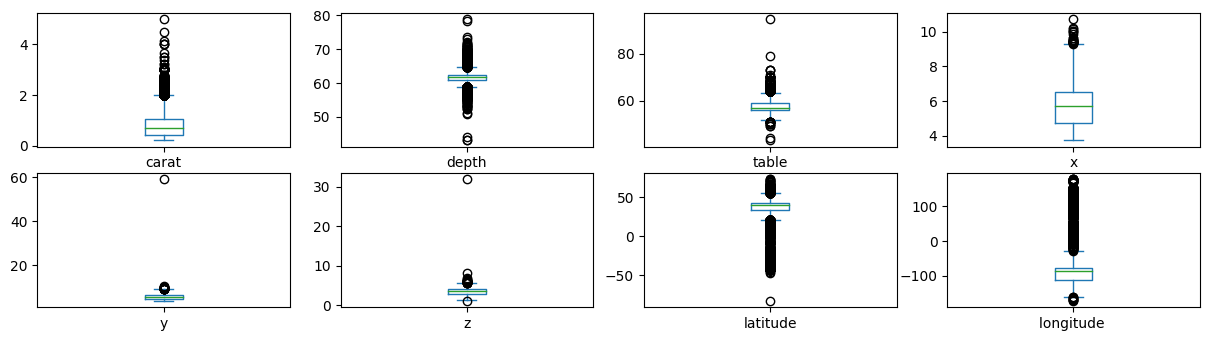

In [103]:
numeric_cols.plot(kind='box',figsize=(15,8),subplots=True,layout=(4,4))
plt.show()

As we can see in the graphics there ara a lot of values out of the 25% and 75% quantiles so we can look for outliers.

In [104]:
def remove_outliers(df, col_name, thres=1.5):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    uplim = Q3 + (thres*IQR)
    lwlim = Q1 - (thres*IQR)

    outliers = df[ (df[col_name] < lwlim) | (df[col_name] > uplim) ]
    print('{} had {} outliers.'.format(col_name, len(outliers)))
    df = df.drop(outliers.index)

    return df

In [105]:
len_data = len(diamons_data)
for col in numeric_cols.columns.tolist():
    diamons_data = remove_outliers(diamons_data, col)

carat had 1772 outliers.
depth had 2644 outliers.
table had 316 outliers.
x had 0 outliers.
y had 0 outliers.
z had 2 outliers.
latitude had 1458 outliers.
longitude  had 2147 outliers.


In [106]:
print('Number of rows before remove outliers: ', len_data)
print('Number of rows after remove outliers: ', len(diamons_data))

Number of rows before remove outliers:  50935
Number of rows after remove outliers:  42596


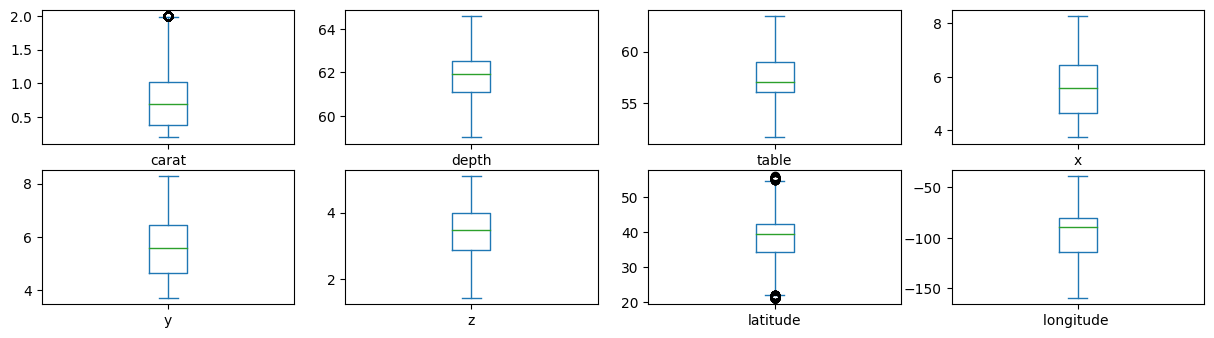

In [107]:
numeric_cols = diamons_data.select_dtypes(include=[np.number]).drop('price', axis=1)
numeric_cols.plot(kind='box',figsize=(15,8),subplots=True,layout=(4,4))
plt.show()

We can also see the coorelation between variables.

In [108]:
corr = diamons_data.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,carat,depth,table,price,x,y,z,latitude,longitude
carat,1.000000,0.031063,0.182995,0.908600,0.985242,0.984548,0.984208,0.001715,0.003168
depth,0.031063,1.000000,-0.227876,-0.001677,-0.011185,-0.013079,0.085289,0.002492,0.000795
table,0.182995,-0.227876,1.000000,0.122415,0.183948,0.178825,0.159626,0.002172,0.001408
price,0.908600,-0.001677,0.122415,1.000000,0.874394,0.875700,0.871254,-0.001817,0.004860
x,0.985242,-0.011185,0.183948,0.874394,1.000000,0.998616,0.994108,0.002893,0.002203
y,0.984548,-0.013079,0.178825,0.875700,0.998616,1.000000,0.993912,0.003302,0.001896
z,0.984208,0.085289,0.159626,0.871254,0.994108,0.993912,1.000000,0.003086,0.001949
latitude,0.001715,0.002492,0.002172,-0.001817,0.002893,0.003302,0.003086,1.000000,-0.039647
longitude,0.003168,0.000795,0.001408,0.004860,0.002203,0.001896,0.001949,-0.039647,1.000000


Since the coor between x, y, z is high (Probably because they explain the diamond size) we can use PCA to convert these variables into 1. We do not include carat due to his high coor with price.

In [109]:
len(diamons_data['x'])

42596

In [110]:
cols_to_pca = ['x', 'y', 'z']

pca = PCA(n_components=1)
pca.fit(diamons_data[cols_to_pca].values)

xyz_pca = pca.transform(diamons_data[cols_to_pca].values)

#diamons_data = diamons_data.drop('x', axis=1).drop('y', axis=1).drop('z', axis=1)
diamons_data['xyz'] = pd.DataFrame(xyz_pca, columns=['xyz']).values

In [111]:
corr = diamons_data.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,carat,depth,table,price,x,y,z,latitude,longitude,xyz
carat,1.000000,0.031063,0.182995,0.908600,0.985242,0.984548,0.984208,0.001715,0.003168,0.985824
depth,0.031063,1.000000,-0.227876,-0.001677,-0.011185,-0.013079,0.085289,0.002492,0.000795,0.003541
table,0.182995,-0.227876,1.000000,0.122415,0.183948,0.178825,0.159626,0.002172,0.001408,0.178087
price,0.908600,-0.001677,0.122415,1.000000,0.874394,0.875700,0.871254,-0.001817,0.004860,0.875355
x,0.985242,-0.011185,0.183948,0.874394,1.000000,0.998616,0.994108,0.002893,0.002203,0.999527
y,0.984548,-0.013079,0.178825,0.875700,0.998616,1.000000,0.993912,0.003302,0.001896,0.999489
z,0.984208,0.085289,0.159626,0.871254,0.994108,0.993912,1.000000,0.003086,0.001949,0.996022
latitude,0.001715,0.002492,0.002172,-0.001817,0.002893,0.003302,0.003086,1.000000,-0.039647,0.003098
longitude,0.003168,0.000795,0.001408,0.004860,0.002203,0.001896,0.001949,-0.039647,1.000000,0.002036
xyz,0.985824,0.003541,0.178087,0.875355,0.999527,0.999489,0.996022,0.003098,0.002036,1.000000


Also we can see than latitude and longitude has low correlation with the price

For categorical variables we can plot their histogram

In [112]:
def plot_histograms(df):
    cat_cols = df.select_dtypes(include=[object])
    
    with sns.axes_style("darkgrid"):
        for col in cat_cols.columns:
            df[col].hist(bins=len(df[col].value_counts()), color='skyblue')
            plt.title(col)
            plt.grid(False)
            plt.show()

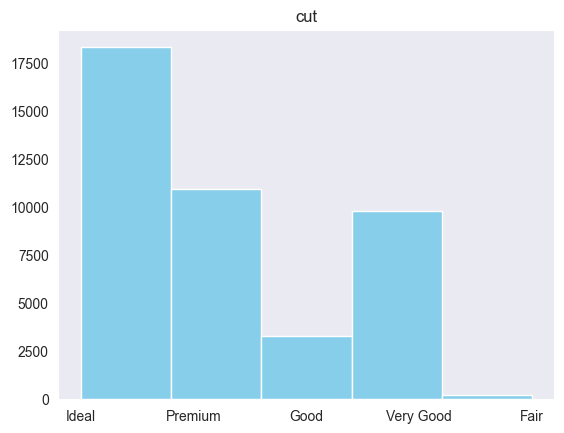

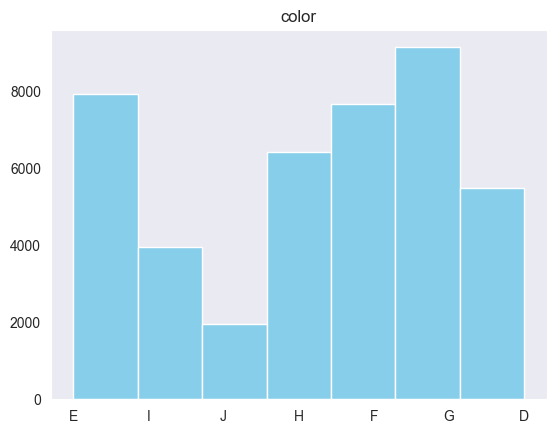

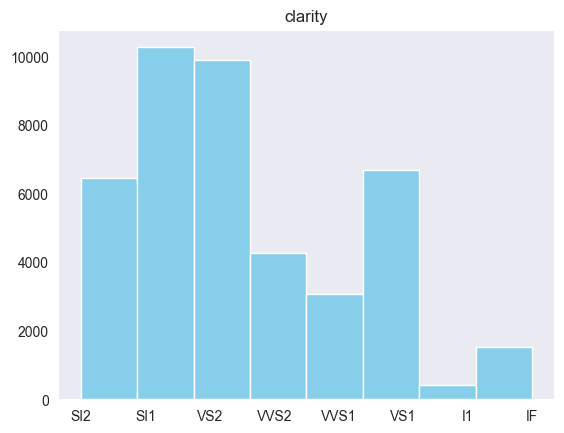

In [113]:
plot_histograms(diamons_data)

From these plot we can se that:
- Good and Fair
- I1 and IF has minimun appearances.
So lets take a look to their price and see if we can merge them.

In [114]:
def compare_price(df, col, val1, val2, obj='price'):
    val1_data = df[df[col]==val1]
    val2_data = df[df[col]==val2]

    print('{} resume: \n {}'.format(val1, val1_data[obj].describe()))
   
    print('\n{} resume: \n {}'.format(val2, val2_data[obj].describe()))
    pass


From these plot we can see that:
- Good and Fair
- I1 and IF has minimun appearances.
So let's take a look at their price and see if we can merge them.


**Cut variable**

In [115]:
compare_price(diamons_data, 'cut', 'Good', 'Fair')

Good resume: 
 count     3313.000000
mean      3518.682463
std       3161.183902
min        335.000000
25%        945.000000
50%       2738.000000
75%       4737.000000
max      18069.000000
Name: price, dtype: float64

Fair resume: 
 count      241.000000
mean      3868.107884
std       2711.581653
min        496.000000
25%       1998.000000
50%       3282.000000
75%       4845.000000
max      17713.000000
Name: price, dtype: float64


Due to "Fair" only has 241 instances and the price seems to have a similiar distribution than "Good" we can merge the two clases.

In [116]:
diamons_data['cut_mod'] = diamons_data['cut'].replace(['Good', 'Fair'], 'GnF')

**Clarity variable**

In [117]:
compare_price(diamons_data, 'clarity', 'I1', 'IF')

I1 resume: 
 count      422.000000
mean      3295.552133
std       1779.578471
min        345.000000
25%       2177.250000
50%       3212.000000
75%       3982.250000
max      10685.000000
Name: price, dtype: float64

IF resume: 
 count     1520.000000
mean      2787.044737
std       3817.051651
min        369.000000
25%        891.000000
50%       1063.000000
75%       2321.000000
max      18806.000000
Name: price, dtype: float64


Even though I1 only has 422 instances their distribution is completely different therefore is not a good idea to join the clases. Also we consider that I1 is the worst clarity possible and IF the best.

## Encoding and spliting the data

In order to measure the value of the Krenk’s diamonds we have to develop a model capable of estimating the price of each diamond. For that we are going to use two train dataset
1. The original dropping coordinates.
2. The moded that use the x,y,z PCA and the join of I1 and IF classes for the Cut variable and dropping coordinates.

in order to predict the **price** variable.

In [118]:
diamons_data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z', 'latitude', 'longitude ', 'xyz', 'cut_mod'],
      dtype='object')

In [119]:
Y  = diamons_data[['price']]
X_original = diamons_data.drop(['cut_mod', 'xyz', 'price', 'latitude', 'longitude '], axis=1)
X_mod = diamons_data.drop(['cut', 'x', 'y', 'z', 'price', 'latitude', 'longitude '], axis=1)

In [120]:
X_original.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [121]:
X_mod.columns

Index(['carat', 'color', 'clarity', 'depth', 'table', 'xyz', 'cut_mod'], dtype='object')

Since the variables Cut and Clarity are Oridinal variables (the clases has an order) we can encode them like that

In [122]:
cut_encoder = OrdinalEncoder(categories=[['Fair','Good','Very Good','Premium','Ideal']])

X_original['cut'] = cut_encoder.fit_transform(X_original.loc[:,['cut']])

In [123]:
cut_mod_encoder = OrdinalEncoder(categories=[['GnF','Very Good','Premium','Ideal']])

X_mod['cut_mod'] = cut_mod_encoder.fit_transform(X_mod.loc[:,['cut_mod']])

In [124]:
X_original['clarity'].value_counts()

SI1     10270
VS2      9901
VS1      6696
SI2      6442
VVS2     4268
VVS1     3077
IF       1520
I1        422
Name: clarity, dtype: int64

In [125]:
clarity_encoder = OrdinalEncoder(categories=[['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']])

X_original['clarity'] = clarity_encoder.fit_transform(X_original.loc[:,['clarity']])
X_mod['clarity'] = clarity_encoder.fit_transform(X_mod.loc[:,['clarity']])

In the other hand, color is not ordinal so there are two options
1. Enumerate the color with no specific order.
2. Use One hot encoding.

In this case we use One hot encoding.

In [126]:
X_original = pd.get_dummies(X_original, columns=['color'])
X_mod = pd.get_dummies(X_mod, columns=['color'])

In [127]:
X_original.describe()

,carat,cut,clarity,depth,table,x,y,z,color_D,color_E,color_F,color_G,color_H,color_I,color_J
count,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000
mean,0.738391,3.027585,3.143746,61.800678,57.252918,5.610002,5.614727,3.468218,0.129120,0.186356,0.180205,0.214668,0.150953,0.092779,0.045920
std,0.400632,1.010598,1.641240,1.077533,2.012668,1.027187,1.021417,0.635198,0.335337,0.389398,0.384362,0.410597,0.358007,0.290125,0.209314
min,0.200000,0.000000,0.000000,59.000000,51.600000,3.730000,3.710000,1.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380000,2.000000,2.000000,61.100000,56.000000,4.660000,4.670000,2.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.700000,3.000000,3.000000,61.900000,57.000000,5.600000,5.600000,3.460000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.020000,4.000000,4.000000,62.500000,59.000000,6.460000,6.460000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,4.000000,7.000000,64.600000,63.500000,8.290000,8.270000,5.090000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [128]:
X_mod.describe()

,carat,clarity,depth,table,xyz,cut_mod,color_D,color_E,color_F,color_G,color_H,color_I,color_J
count,42596.000000,42596.000000,42596.000000,42596.000000,4.259600e+04,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000,42596.000000
mean,0.738391,3.143746,61.800678,57.252918,-1.898295e-16,2.033243,0.129120,0.186356,0.180205,0.214668,0.150953,0.092779,0.045920
std,0.400632,1.641240,1.077533,2.012668,1.580068e+00,0.996330,0.335337,0.389398,0.384362,0.410597,0.358007,0.290125,0.209314
min,0.200000,0.000000,59.000000,51.600000,-2.908004e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380000,2.000000,61.100000,56.000000,-1.461260e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.700000,3.000000,61.900000,57.000000,1.444802e-02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.020000,4.000000,62.500000,59.000000,1.304847e+00,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,7.000000,64.600000,63.500000,4.010014e+00,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
Y = Y.values
X_mod = X_mod.values
X_original = X_original.values

In [130]:
X_mod_train, X_mod_valid, y_mod_train, y_mod_valid = train_test_split(X_mod, Y, test_size=0.2, random_state=333)
X_original_train, X_original_valid, y_original_train, y_original_valid = train_test_split(X_original, Y, test_size=0.2, random_state=333)

## Modeling data

In order to train and evalueate diferente models and hiperparemeters we make a grid search for each model.

In [60]:
def train_and_eval(model, parameters, x_train, x_valid, y_train, y_valid, model_name=''):
    clf = GridSearchCV(model, parameters, n_jobs=-1)
    clf.fit(x_train, y_train.reshape((1,-1))[0])

    y_pred = clf.predict(x_valid)
    
    print(\
        'Evaluation metrics for {}. \n   RMSE:{}, MAE:{}, R2:{} \n'.format(model_name, np.sqrt(mse(y_valid,y_pred)), mae(y_valid,y_pred), r2(y_valid,y_pred))
        )
    print("The best parameters across ALL searched params:\n", clf.best_params_)

### Regresion lineal

In [55]:
model = LinearRegression()
parameters = {}

train_and_eval(model, parameters, X_mod_train, X_mod_valid, y_mod_train, y_mod_valid, model_name='Linear regresion with X_mod')
print('\n')

model = LinearRegression()
train_and_eval(model, parameters, X_original_train, X_original_valid, y_original_train, y_original_valid, model_name='Linear regresion with X_original')

Evaluation metrics for Linear regresion with X_mod. 
   RMSE:1033.1540372260738, MAE:687.4510026527057, R2:0.9089834896007545 

The best parameters across ALL searched params:
 {}


Evaluation metrics for Linear regresion with X_original. 
   RMSE:1031.4260304449092, MAE:686.8720657276996, R2:0.909287695196782 

The best parameters across ALL searched params:
 {}


### Decision Tree

In [57]:
model = DecisionTreeRegressor()
parameters = {'criterion':['squared_error'],
              'splitter': ['best', 'random'],
              'max_depth':[None, 2, 4, 6],
              'max_features':[None, 'sqrt', 'log2'],
              }

train_and_eval(model, parameters, X_mod_train, X_mod_valid, y_mod_train, y_mod_valid, model_name='Decision Tree with X_mod')
print('\n')
train_and_eval(model, parameters, X_original_train, X_original_valid, y_original_train, y_original_valid, model_name='Decision Tree with X_original')

Evaluation metrics for Decision Tree with X_mod. 
   RMSE:595.33219742714, MAE:303.0887323943662, R2:0.9697790043283915 

The best parameters across ALL searched params:
 {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'splitter': 'random'}


Evaluation metrics for Decision Tree with X_original. 
   RMSE:587.3923459702723, MAE:303.81578638497655, R2:0.9705797341678932 

The best parameters across ALL searched params:
 {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'splitter': 'random'}


### Random Forest

In [59]:
model = RandomForestRegressor()
parameters = {'criterion':['squared_error'],
              'n_estimators': [100],
              'max_features':[None],
              'bootstrap':[True, False]
              }

train_and_eval(model, parameters, X_mod_train, X_mod_valid, y_mod_train, y_mod_valid, model_name='Random Forest with X_mod')
print('\n')
train_and_eval(model, parameters, X_original_train, X_original_valid, y_original_train, y_original_valid, model_name='Random Forest with X_original')

Evaluation metrics for Random Forest with X_mod. 
   RMSE:438.6001514890908, MAE:235.90605567711827, R2:0.9835968377396724 

The best parameters across ALL searched params:
 {'bootstrap': True, 'criterion': 'squared_error', 'max_features': None, 'n_estimators': 100}


Evaluation metrics for Random Forest with X_original. 
   RMSE:429.2466823144159, MAE:221.68606641143157, R2:0.9842889966737512 

The best parameters across ALL searched params:
 {'bootstrap': True, 'criterion': 'squared_error', 'max_features': None, 'n_estimators': 100}


### Gradient Boost

In [68]:
model = GradientBoostingRegressor()
parameters = {'loss':['squared_error'],
              'max_depth': [3, 6],
              'learning_rate': [0.05, 0.1, 0.3],
              'n_estimators': [100],
              }

train_and_eval(model, parameters, X_mod_train, X_mod_valid, y_mod_train, y_mod_valid, model_name='Gradient Boost with X_mod')
print('\n')
train_and_eval(model, parameters, X_original_train, X_original_valid, y_original_train, y_original_valid, model_name='Gradient Boost with X_original')

Evaluation metrics for Gradient Boost with X_mod. 
   RMSE:426.5775939262246, MAE:233.21101890082628, R2:0.9844837736339336 

The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 100}


Evaluation metrics for Gradient Boost with X_original. 
   RMSE:426.84925990822177, MAE:230.88023756525456, R2:0.9844640043203654 

The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 100}


### Suport Vector Machine

In [62]:
def train_svm(x_train, x_valid, y_train, y_valid, model_name=''):
    model = SVR()
   
    model.fit(x_train, y_train)

    y_pred = model.predict(x_valid)
    
    print(\
        'Evaluation metrics for {}. \n   RMSE:{}, MAE:{}, R2:{} \n'.format(model_name, np.sqrt(mse(y_valid,y_pred)), mae(y_valid,y_pred), r2(y_valid,y_pred))
        )

In [63]:
train_svm(X_mod_train, X_mod_valid, y_mod_train.reshape((1,-1))[0], y_mod_valid, model_name='SVM with X_mod')
print('\n')
train_svm(X_original_train, X_original_valid, y_original_train.reshape((1,-1))[0], y_original_valid, model_name='SVM with X_original')

Evaluation metrics for SVM with X_mod. 
   RMSE:3645.5000353515484, MAE:2427.119672844537, R2:-0.13319393079349195 



Evaluation metrics for SVM with X_original. 
   RMSE:3645.3594476054427, MAE:2426.9559921158343, R2:-0.13310652982948112 



## Predict the price of Krenk’s diamonds

From previous result we consider that use any of the dataset proposed and a **Gradient Boost** with parameters:
- 'learning_rate': 0.1
- 'loss': 'squared_error'
- 'max_depth': 6
- 'n_estimators': 100
Results in the best model to predict the diamonds price. In this case we decide to use the original dataset in order to get more explainability

In order to predict the price of Krenk’s diamonds its necessary to adjust the data first.

In [131]:
diamons_stolen.columns

Index(['Carat', 'Cut', 'Color', 'Clarity', 'Depth', 'Table', 'x', 'y', 'z',
       'latitude', 'longitude'],
      dtype='object')

In [132]:
diamons_stolen = diamons_stolen.drop(['latitude', 'longitude'], axis=1)
diamons_stolen['Cut'] = cut_encoder.fit_transform(diamons_stolen.loc[:,['Cut']])
diamons_stolen['Clarity'] = clarity_encoder.fit_transform(diamons_stolen.loc[:,['Clarity']])
diamons_stolen = pd.get_dummies(diamons_stolen, columns=['Color'])
diamons_stolen.insert(loc = 14,
          column = 'Color_H',
          value = 0)

In [133]:
diamons_stolen.describe()

,Carat,Cut,Clarity,Depth,Table,x,y,z,Color_D,Color_E,Color_F,Color_G,Color_I,Color_J,Color_H
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.604000,3.100000,3.800000,62.180000,56.680000,5.305000,5.332000,3.309000,0.100000,0.100000,0.100000,0.400000,0.200000,0.100000,0.0
std,0.271506,1.197219,1.229273,0.736056,1.592203,0.756575,0.767547,0.486586,0.316228,0.316228,0.316228,0.516398,0.421637,0.316228,0.0
min,0.320000,1.000000,1.000000,60.900000,54.800000,4.430000,4.400000,2.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.392500,3.000000,3.250000,61.725000,55.250000,4.682500,4.717500,2.905000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.505000,3.500000,4.000000,62.100000,56.500000,5.155000,5.165000,3.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.800000,4.000000,4.750000,62.625000,57.750000,5.925000,5.965000,3.707500,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
max,1.120000,4.000000,5.000000,63.300000,59.000000,6.640000,6.660000,4.130000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [134]:
X_test = diamons_stolen.values

In [135]:
model = GradientBoostingRegressor(learning_rate=0.1, loss='squared_error', max_depth=6, n_estimators = 100)
model.fit(X_original_train, y_original_train.reshape((1,-1))[0])


GradientBoostingRegressor(max_depth=6)

In [136]:
y_pred = model.predict(X_original_valid)

print(\
    'Evaluation metrics for {}. \n   RMSE:{}, MAE:{}, R2:{} \n'.format('Gradient Boosting', np.sqrt(mse(y_original_valid,y_pred)), mae(y_original_valid,y_pred), r2(y_original_valid,y_pred))
    )

Evaluation metrics for Gradient Boosting. 
   RMSE:426.9536310364363, MAE:231.09416214936437, R2:0.9844564058176096 



In [137]:
y_pred = model.predict(X_test)

In [138]:
sum(y_pred)

25965.036171255408

## Conclusions